In [3]:
import qutip
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, formatter={"float":lambda x: str(.001*int(1000*x)) })

In [12]:
# rutinas auxiliares:

def check_zero(op):
    return max(abs(op.eigenenergies()))<1.e-10

def scalar_product_t(op1, op2, rho0):
    return (rho0*op1.dag()*op2).tr()

def scalar_product_r(op1, op2, rho0):
    return 0.5*(rho0*(op1.dag()*op2+op2*op1.dag())).tr()

def gs_basis(basis0, rho0, sc_prod):
    new_basis = []
    
    for b in basis0:
        nb = b - sum(sc_prod(w, b, rho0)*w for w in new_basis)
        norm = sc_prod(nb, nb, rho0)**.5
        if norm >1.e-10:
            new_basis.append(nb/norm)
    return new_basis


# Construimos los operadores bÃ¡sicos

n=3
id_loc = qutip.qeye(2)
sz_loc = .5*qutip.sigmaz()
sx_loc = .5*qutip.sigmax()
sy_loc = .5*qutip.sigmay()




# Operadores globales de mi base
id_glob = qutip.tensor([id_loc for i in range(n)])

magnetization = sum(qutip.tensor([(sz_loc)]) for k in range(n))

n_oc =  sum(qutip.tensor([id_loc for i in range(k)]+ 
                     [(sz_loc + .5*id_loc)]+ 
                     [id_loc for i in range(n-k-1)]
                    ) for k in range(n-1))



# Hamiltoniano
H = 2*(sum(qutip.tensor([id_loc for i in range(k)]+ 
                     [sx_loc, sx_loc]+ 
                     [id_loc for i in range(n-k-2)]
                    ) for k in range(n-2)) + 
    sum(qutip.tensor([id_loc for i in range(k)]+ 
                     [sy_loc, sy_loc]+ 
                     [id_loc for i in range(n-k-2)]
                    ) for k in range(n-2)) + 
    qutip.tensor([sx_loc]+[id_loc for i in range(n-2)]+[sx_loc]) + 
    qutip.tensor([sy_loc]+[id_loc for i in range(n-2)]+[sy_loc]) 
   )


x = sum(qutip.tensor([id_loc for i in range(k)]+ 
                     [(k-n/2)*(sz_loc + .5*id_loc)]+ 
                     [id_loc for i in range(n-k-1)]
                    ) for k in range(n-1))


p = 1j*(H*x-x*H)
ac = 1j*(H*p-p*H)

corr = .5*(x*p+p*x)
comm = -1j*(x*p-p*x)

print({"[H,n_op]=0":check_zero(H*n_oc-n_oc*H),
"[x,n_op]=0":check_zero(x*n_oc-n_oc*x),
"[p,n_op]=0":check_zero(p*n_oc-n_oc*p),
"[comm,n_op]=0":check_zero(comm*n_oc-n_oc*comm),
"[corr,n_op]=0":check_zero(corr*n_oc-n_oc*corr)})



psi0 = ((1-.1j)*qutip.tensor([qutip.basis(2,1) for k in range(int(n/2)-1)]+
                    [qutip.basis(2,0)]+
                    [qutip.basis(2,1) for k in range(int(n/2+.5))]
                   )
        -
        (1+.1j)*qutip.tensor([qutip.basis(2,1) for k in range(int(n/2))]+
                    [qutip.basis(2,0)]+
                    [qutip.basis(2,1) for k in range(int(n/2+.5)-1)]
                   )
       )*np.sqrt(.5/1.01)



print("valores medios iniciales:",{name:qutip.expect(op, psi0) for name, op in zip(["n_oc","x","p", "[x,p]/I", 
                                                                         "I [H,p]"],[n_oc, x,p,comm, ac])})


rho0=psi0*psi0.dag()



{'[H,n_op]=0': False, '[x,n_op]=0': True, '[p,n_op]=0': False, '[comm,n_op]=0': False, '[corr,n_op]=0': False}
valores medios iniciales: {'n_oc': 1.0, 'x': -1.0, 'p': 0.19801980198019806, '[x,p]/I': 0.9801980198019803, 'I [H,p]': 1.5000000000000004}


valores medios iniciales: {'n_oc': 1.2295069703019266, 'x': -3.4911145182409324, 'p': -0.17227173883091176, '[x,p]/I': 1.3246707069257064, 'I [H,p]': 2.7737957713656627}


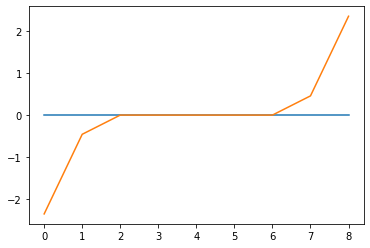

In [106]:
rho_ref = (-H-.5*(n_oc-id_glob)**2).expm()
rho_ref = rho_ref/rho_ref.tr()

ops=[id_glob, n_oc, n_oc**2, x, p , ac, comm, corr, H]

gr_basis = gs_basis(ops, rho_ref, scalar_product_r)

# condiciones iniciales
phi0 = [0., 4., 2.,  2., .1, 0., -.2, 0., 0.]
rho0 = (-sum( f*op  for f, op in  zip(phi0, gr_basis))).expm()
phi0[0]=np.log(rho0.tr())
rho0 = (-sum( f*op  for f, op in  zip(phi0, gr_basis))).expm()

print("valores medios iniciales:",{name:qutip.expect(op, rho0) for name, op in zip(["n_oc","x","p", "[x,p]/I", 
                                                                         "I [H,p]"],[n_oc, x,p,comm, ac])})

HijT = np.array([[scalar_product_r(op2, -1j*(H*op1-op1*H),rho_ref) for op1 in gr_basis] for op2 in gr_basis])
plt.plot(qutip.Qobj(HijT).eigenenergies().real)
plt.plot(sorted(qutip.Qobj(HijT).eigenenergies().imag))

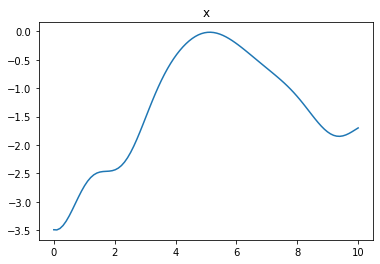

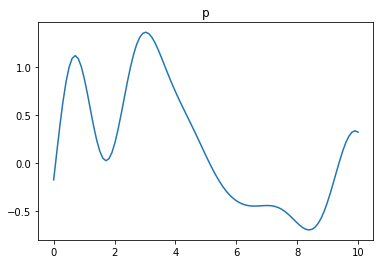

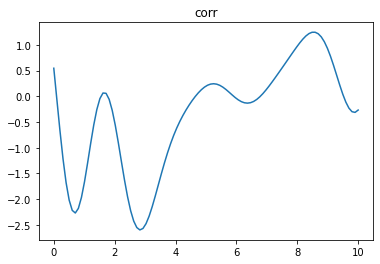

In [97]:
# DinÃ¡mica exacta
res=qutip.mesolve(H, rho0, np.linspace(0,10,100), c_ops=None, e_ops=[x,p,corr])

for indx, name in enumerate(["x", "p", "corr"]):
    plt.title(name)
    plt.plot(res.times, res.expect[indx])
    plt.show()


In [73]:


gt_basis = gs_basis(ops, rho_ref, scalar_product_t)

In [88]:
HijT = np.array([[scalar_product_r(op2, -1j*(H*op1-op1*H),rho_ref) for op1 in gr_basis] for op2 in gr_basis])

HijT.real

array([[0.0, 0.0, 0.0, ..., 0.0, -0.074, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, -0.069, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.367, 0.0],
       ...,
       [0.0, 0.0, 0.0, ..., 0.0, 0.341, 0.0],
       [0.0, -0.053, -0.022, ..., -0.232, 0.0, -0.156],
       [0.0, 0.0, 0.0, ..., 0.0, 0.107, 0.0]])

$$
\frac{d \phi_i}{dt} = \sum_j{\cal H}_{ij}\phi_j
$$

$$
\phi_i(t)= \exp({\cal H}_{ij} t) \phi_j
$$

In [ ]:
gramm_r=np.array([[ scalar_product_r(b1, b2,rho_ref)  for b1 in gr_basis] for b2 in gr_basis])
gramm_t=np.array([[ scalar_product_t(b1, b2,rho_ref)  for b1 in gr_basis] for b2 in gr_basis])

In [ ]:
gramm_t.imag

In [ ]:
np.array([[ scalar_product_t(b1, b2,rho_ref).real  for b1 in gr_basis] for b2 in gr_basis])

In [ ]:
norm(np.array([[0,1],[1,2]]))